Calculate heat flux budget to estimate relative contributions of local surface heat flux and advection to total heat flux. 
Performs this calculation and makes plots for one experiment set at a time. 

Q_total = Q_surf + Q_adv

Q_total = p_sw * C_sw * h * dT/dt

Total heat flux = density of seawater * heat capacity of sw * depth of water column * change in Temp over time
    W/m^2 =            (kg/m^3) *            (J/ kgK) *              (m) *                     (K/s)
J = W s

In [12]:
from matplotlib import pyplot as plt
import numpy as np
from Datasets import wind_order_forcings, warm_order_forcings,\
exp_set_dict_wind_order, exp_set_dict_warm_order, colors_dict, all_runs_wind_order
import Functions_load_output as flo
import Functions_data_analysis as fda
import Functions_plotting as fp
from scipy.stats import linregress

In [15]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_plotting.py'>

In [3]:
# Set up variable parameters

loc = 'inner_shelf_corner' #'PITT', 'PIG' #refer to load T and Q cell. currently searches trough_idx_dict keys


Retrieving U and V data in year 1999 for all 10 experiments to calculate velocities at depth: -400
Getting U data for all runs...
0
saving date from these times for 1st run:
 [cftime.DatetimeNoLeap(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 2, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 3, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 4, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 5, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 6, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 7, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 8, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 11, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1999, 12, 1, 0, 0, 0, 0, has_year_zero=True)]
(12, 254, 301)
la

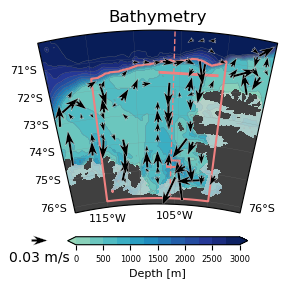

In [44]:
# Show locations of cross sections on bathymetry map
importlib.reload(fp)
fp.plot_bathymetry_and_locs('AS_near', ['EOT','PITT','ET_2','naughten_shelf_box'],plot_velocity=True, velocity_depth=-400)
plt.savefig('Plots/Figure_bathymetry_map_with_locs_quivers.png',dpi=600)

In [5]:
# set up data retrieval params
set = 'ic_1995' #'ic_1995','ic_2001','ic_2008'
colors = colors_dict[set]
runs = exp_set_dict_wind_order[set]
runs

['run_forc_erai_2015_rep_ic_1995',
 'run_forc_erai_1991_rep_ic_1995',
 'run_forc_erai_1982_rep_ic_1995',
 'run_forc_erai_1994_rep_ic_1995',
 'run_forc_erai_1992_rep_ic_1995',
 'run_forc_erai_1984_rep_ic_1995',
 'run_forc_erai_2009_rep_ic_1995',
 'run_forc_erai_2003_rep_ic_1995',
 'run_forc_erai_1989_rep_ic_1995',
 'run_forc_erai_2011_rep_ic_1995']

In [9]:
# Load surface qnet for each run (using avg over lat and lon dims)

q_surf_dict = {}
q_surf_winter_dict = {}
forcings = []
for run in runs:
    print(run)
    exp_q_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').oceQnet
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[loc]
        exp_q_reg = exp_q_full.isel(lat=slice(lati1, lati2), 
                                    lon=slice(loni1, loni2),
                                    time=slice(0, 60))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[loc]
        exp_q_reg = exp_q_full.sel(lat=slice(lat1, lat2), 
                                    lon=slice(lon1, lon2))
        exp_q_reg = exp_q_reg.isel(time=slice(0, 60))
    exp_q = exp_q_reg.mean(dim='lat')
    exp_q_surf = exp_q.mean(dim='lon')
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'
    q_surf_dict[forc] = exp_q_surf
    forcings.append(forc)

    # only include winter/spring months (JJASON)
    winter_months = exp_q_surf.time.dt.month.isin([6,7,8,9,10,11])
    
    # Select winter months and calculate the mean
    exp_q_surf_winter = exp_q_surf.sel(time=winter_months)
    q_surf_winter_dict[forc] = exp_q_surf_winter


print('q_surf_dict generated!')

run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
q_surf_dict generated!


2015_x5 13.714542388916016
1991_x5 20.10547637939453
1982_x5 32.66325378417969
1994_x5 3.3153421878814697
1992_x5 23.1812744140625
1984_x5 43.09226989746094
2009_x5 7.6869964599609375
2003_x5 11.879602432250977
1989_x5 37.7142448425293
2011_x5 23.163902282714844


Text(0.5, 1.0, 'OceQnet')

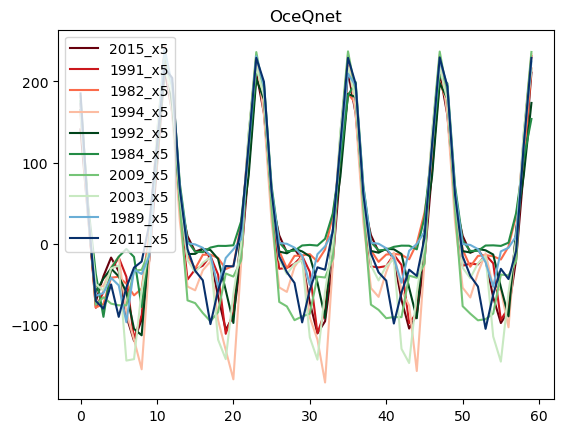

In [25]:
plt.figure()
for i in range(10):
    print(forcings[i],float(np.mean(q_surf_dict[forcings[i]])))
    plt.plot(q_surf_dict[forcings[i]],label=forcings[i],color=colors[i])
plt.legend()
plt.title('OceQnet')
# plt.xlim(0,12)


Text(0.5, 1.0, 'Winter OceQnet')

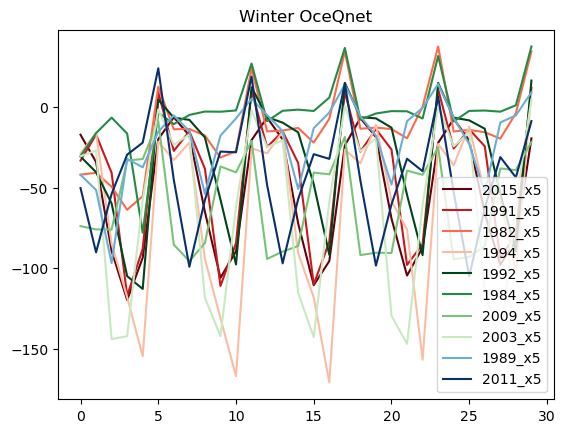

In [14]:
plt.figure()
for i in range(10):
    plt.plot(q_surf_winter_dict[forcings[i]],label=forcings[i],color=colors[i])
plt.legend()
plt.title('Winter OceQnet')
# plt.xlim(0,12)
# variability is greater in winter so maybe the 

In [15]:
# Calculate 5-yr-avg Q_total (rather than monthly tseries)

def calc_5yr_mean_Q_total(run, loc):
    """
    Calculate 5-yr-mean heat flux at a specified location in an experiment using the formula
    Q_total = p_sw * C_sw * h * dT/dt
    Total heat flux = density of seawater * heat capacity of sw * depth of water column * change in Temp over time
    W/m^2 = (kg/m^3) * (J/ kgK) * (m) * (K/s)

    Model depth is variable, so h * dT/dt component is the summation of each deltaZ * mean dT/dt over 5 yrs (each z)
    The mean dT/dt over 5 yrs = linear slope of T in units of K / secs_per_month

    Inputs
    ------
    run: str
        experiment name
    loc: str
        location over which to average data, corresponds to trough_idx_dict key

    Outputs
    -------
    q_total: float
        contains value of q_total, in units of W/m^2
    """
    
    # Assign constants
    rho_sw = 1025  # kg/m^3 
    C_sw = 4200  # J/ kgK 
    secs_per_month = 60*60*24*365/12 # secs; 60 secs/min * 60 mins/hr * 24 hrs/day * avg days per month

    # Load T in region
    exp_T_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[loc]
        exp_T_reg = exp_T_full.isel(lat=slice(lati1, lati2), 
                                lon=slice(loni1, loni2),
                                time=slice(0, 60))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[loc]
        exp_T_reg = exp_T_full.sel(lat=slice(lat1, lat2), 
                                    lon=slice(lon1, lon2))
        exp_T_reg = exp_T_reg.isel(time=slice(0, 60))

    times = np.arange(60)
    
    # Average on x/y axes (revise to do weighted average based on grid sizes)
    exp_T_avg_lat = exp_T_reg.mean(dim='lat')
    exp_T_avg_area = exp_T_avg_lat.mean(dim='lon')

    # Get average T in z axis (weighted to thickness of layer)
    sum_hdTdt = 0
    depths = exp_T_avg_area.depth
    # calculate delta_h * (mean dT/dt) for each depth layer i
    for i in range(len(depths)-1):
        T_i = exp_T_avg_area.isel(depth=i)
        # slope, _ = np.polyfit(times, T_i, 1) # calculate monthly slope using all 5 yrs
        # dTdt = slope / secs_per_month
        # taking diff btween 5th yr mean and 1st yr mean is much faster than calulating slope
        #dT_5yrs = np.mean(T_i[-12:]) - np.mean(T_i[0:12]) #xr data array
        #dTdt = dT_5yrs / (secs_per_month * 60)
        # simplest is to take diff of 1st and last value
        dTdt = (T_i[-1] - T_i[0]) / (secs_per_month * 60)
        delta_h = depths[i] - depths[i+1]  # positive h
        h_dTdt_i = float(delta_h * (dTdt))
        if i%10 == 0:
            print(i, 'h_dTdt_i',h_dTdt_i)
        sum_hdTdt += h_dTdt_i

    # calculate estimate of Q using formula
    q_total = rho_sw * C_sw * sum_hdTdt

    return q_total

In [28]:
# Calculate 5-yr-mean q total in each run (slow)
save = False # Check filename below

# list containing floats of q, ordered by run order
q_surf = []
q_adv = []
forcs = []
try:
    q_total = list(np.load('Saved Arrays/Heat Budget/'+loc+'_'+set+'_q_total_dTdt_simple.npy'))
    precalc = True
    save = False
except:
    q_total = []
    precalc = False
    if not save:
        print('Caution - will NOT save q_total after calculating!')
    
for i in range(len(runs)):

    run = runs[i]
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'

    # Calculate Q total
    if precalc:
        q_total_run = q_total[i]
    else:
        print('Calculating q total for run',run)
        q_total_run = calc_5yr_mean_Q_total(run, loc)
        q_total.append(q_total_run)

    # Calculate q adv
    q_surf_run_mean = np.mean(q_surf_dict[forc].values) #take 5-yr mean q surf
    q_surf.append(q_surf_run_mean)
    q_adv_run = q_total_run - q_surf_run_mean
    q_adv.append(q_adv_run)

if save:
    np.save('Saved Arrays/Heat Budget/'+loc+'_'+set+'_q_total_dTdt_simple.npy', np.array(q_total))
    print('Saved')

print('q total calculated!')

q total calculated!


In [29]:
forcings = []
for i in range(len(runs)):
    run = runs[i]
    print(run)
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'
    forcings.append(forc)
    print('Q total:{:.2f}'.format(q_total[i])+\
          ', Q surf:{:.2f}'.format(q_surf[i])+\
          ', Q adv:{:.2f}'.format(q_adv[i]))
    print('Q surf contributes {:.4f}'.format(q_surf[i]/q_total[i]))
    

run_forc_erai_2015_rep_ic_1995
Q total:-3.27, Q surf:13.71, Q adv:-16.99
Q surf contributes -4.1925
run_forc_erai_1991_rep_ic_1995
Q total:-4.31, Q surf:20.11, Q adv:-24.41
Q surf contributes -4.6664
run_forc_erai_1982_rep_ic_1995
Q total:1.01, Q surf:32.66, Q adv:-31.65
Q surf contributes 32.1982
run_forc_erai_1994_rep_ic_1995
Q total:-28.83, Q surf:3.32, Q adv:-32.15
Q surf contributes -0.1150
run_forc_erai_1992_rep_ic_1995
Q total:-1.98, Q surf:23.18, Q adv:-25.16
Q surf contributes -11.6897
run_forc_erai_1984_rep_ic_1995
Q total:-0.71, Q surf:43.09, Q adv:-43.80
Q surf contributes -61.1077
run_forc_erai_2009_rep_ic_1995
Q total:-9.34, Q surf:7.69, Q adv:-17.03
Q surf contributes -0.8228
run_forc_erai_2003_rep_ic_1995
Q total:-14.93, Q surf:11.88, Q adv:-26.81
Q surf contributes -0.7955
run_forc_erai_1989_rep_ic_1995
Q total:-0.13, Q surf:37.71, Q adv:-37.84
Q surf contributes -295.5684
run_forc_erai_2011_rep_ic_1995
Q total:-5.65, Q surf:23.16, Q adv:-28.82
Q surf contributes -4.09

Text(0.5, 1.0, 'inner_shelf_corner, ic_1995')

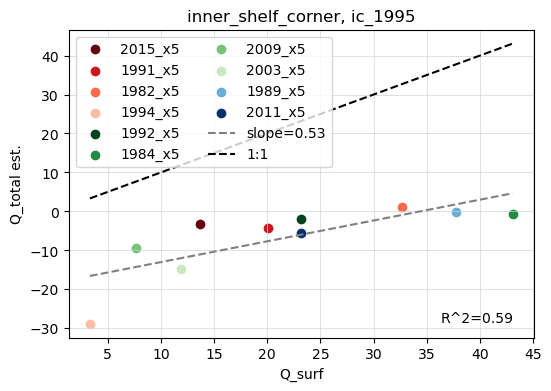

In [37]:
# Plot scatter plot of Q surf vs Q total and calc R^2 val

plt.figure(figsize=(6,4))
for i in range(len(runs)):
    plt.scatter(q_surf[i], q_total[i], color=colors[i], label=forcings[i])

slope, intercept, r_value, p_value, std_err = linregress(q_surf,q_total)
x_vals = np.linspace(min(q_surf),max(q_surf),20)
plt.plot(x_vals, slope * x_vals + intercept,linestyle='--',
         label='slope={:.2f}'.format(slope),color='gray')
plt.plot(x_vals, x_vals, linestyle='--', label='1:1',
         color='k')

# Calculate R^2 to est. the proportion of the variance in Q_total that can be explained by the variance in Q_surf
correlation_matrix = np.corrcoef(q_surf, q_total)
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient**2

plt.grid(linewidth=0.5, color='lightgray')
plt.annotate('R^2={:.2f}'.format(r_squared), xy=(0.80, 0.05), xycoords='axes fraction')
plt.xlabel('Q_surf')
plt.ylabel('Q_total est.')
plt.legend(loc='upper left',ncol=2)
plt.title(loc +', '+ set)

In [31]:
r_squared

0.5886868467874569

In [37]:
"""
# Load surface qnet for each run using weighted avg based on grid areas (makes minimal diff; see plot below)

q_surf_dict_weighted = {}
for run in runs:
    print(run)
    lati1, lati2, loni1, loni2 = fda.trough_idx_dict[loc]

    exp_q_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').oceQnet
    exp_q_reg = exp_q_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2),
                                time=slice(0, 60))
    print('exp_q_reg[:,0:-1,0:-1] shape:', exp_q_reg[:, 0:-1, 0:-1].shape)
    # calculate cell-area-weighted average of T (avging over lat and lon is may be insufficient due to unequal grid areas)
    # Calculate grid areas for first run only, then reuse
    if run == runs[0]:
        grid_areas = fda.calc_grid_areas(exp_q_reg)
        # standardize grid areas to get weights
        weights = grid_areas / np.sum(grid_areas)
        weights_3d = np.expand_dims(weights, axis=0)
        print('weights', weights.shape)
        # Calculate weighted avg timeseries
    exp_q_weighted = np.sum(exp_q_reg[:, 0:-1, 0:-1] * weights_3d, axis=(1, 2))
    # Populate dictionary
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'
    q_surf_dict_weighted[forc] = exp_q_weighted.values

print('q_surf_dict_weighted generated!')
"""

run_forc_erai_2015_rep_ic_1995
exp_q_reg[:,0:-1,0:-1] shape: (60, 9, 19)
distance between first set of lats: -74.62774 -74.65137 : 2627.33984236314 meters
distance between first set of lons: -106.208336 -106.125 , 9266.526670368372 meters
weights (9, 19)
q_surf_dict_weighted generated!


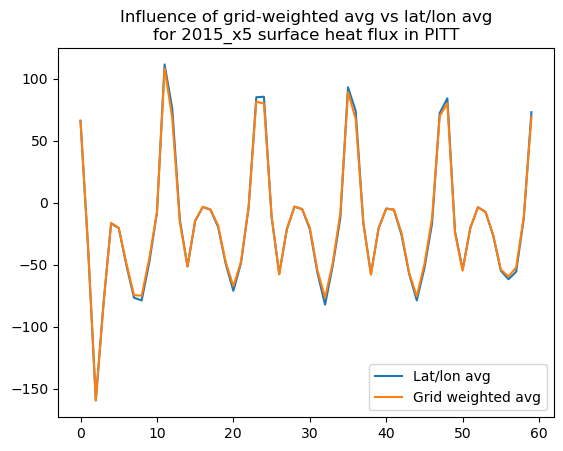

In [42]:
"""
# Show difference between avging over lat/lon (simple) vs weighted avg for 2015 experiment
plt.figure()
plt.plot(q_surf_dict['2015_x5'], label='Lat/lon avg')
plt.plot(q_surf_dict_weighted['2015_x5'], label='Grid weighted avg')
plt.title('Influence of grid-weighted avg vs lat/lon avg\nfor 2015_x5 surface heat flux in '+loc)
plt.legend()
# The difference is very minimal, probable because the region size is quite small (10x20 cells).
"""

In [53]:
# Define function to calculate monthly total heat flux in each run (old)

def calc_monthly_Q_total(run, loc):
    """
    Calculate heat flux at a specified location in an experiment using the formula
    Q_total = p_sw * C_sw * h * dT/dt
    Total heat flux = density of seawater * heat capacity of sw * depth of water column * change in Temp over time
    W/m^2 = (kg/m^3) * (J/ kgK) * (m) * (K/s)

    depth 

    Performs calculation over 60 months in each experiment. Returns 59 values bc dT/dt taken.

    Inputs
    ------
    run: str
        experiment name
    loc: str
        location over which to average data, corresponds to trough_idx_dict key

    Outputs
    -------
    q_total: 1d np array with length 59
        contains values of q_total
    h: int
        height of water column in region (after averaging by area)
    """
    # Assign constants
    rho_sw = 1025  # kg/m^3 
    C_sw = 4200  # J/ kgK 

    # Load T in region
    lati1, lati2, loni1, loni2 = fda.trough_idx_dict[loc]
    exp_T_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    exp_T_reg = exp_T_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2),
                                time=slice(0, 60))
    
    # Average on x/y axes (revise to do weighted average based on grid sizes)
    exp_T_avg_lat = exp_T_reg.mean(dim='lat')
    exp_T_avg_area = exp_T_avg_lat.mean(dim='lon')
    h = -exp_T_avg_area.depth[-1] #positive h

    # Get average T in z axis (weighted to thickness of layer)

    exp_T_times_depth = 0
    depths = exp_T_reg.depth
    for i in range(len(exp_T_avg_area.depth)-1):
        T_depth_i = exp_T_avg_area.isel(depth=i)
        delta_h = depths[i] - depths[i+1]  #positive delta_h
        exp_T_times_depth += T_depth_i * delta_h
        print(i, delta_h, T_depth_i, exp_T_times_depth_i)
    exp_T_avg_depth = exp_T_times_depth / h

    # Calculate the gradient of T (dT/dt)
    delta_T_per_month = exp_T.compute().diff('time')
    # dt is 1 month, so need to convert to seconds
    month_secs = 60*60*24*365 / 12
    delta_T = delta_T_per_month / month_secs

    # calculate estimate of Q using formula
    q_total = rho_sw * C_sw * h * delta_T

    return q_total

In [71]:
q_surf_run_mean = np.mean(q_surf_dict[forc]) #take 5-yr mean q surf
q_adv_run = q_total_run - q_surf_run_mean
q_adv.append(q_adv_run)
print('Q adv:',q_adv_run)

Q adv: 0.28652161866874515


In [54]:
# Calculate monthly q total in each run

q_total_dict = {}
q_adv_dict = {}
q_surf_pct_dict = {}
for run in runs:
    
    print(run)

    # Calculate Q total
    q_total = calc_monthly_Q_total(run, loc)
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'
    q_total_dict[forc] = q_total
    print('Q total calculated')

    # Calculate q adv
    q_surf = q_surf_dict[forc][0:-1]
    q_adv = q_total - q_surf
    q_adv_dict[forc] = q_adv
    
    # calculate percent contribution of q surface to q_total
    # Because some vals are -, take the difference of the abs vals between q_surf and q_adv 
    q_surf_pct = (abs(q_surf) / (abs(q_surf)+abs(q_adv))) * 100
    q_surf_pct_dict[forc] = q_surf_pct

run_forc_erai_2015_rep_ic_1995


ValueError: applied function returned data with unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names: ()

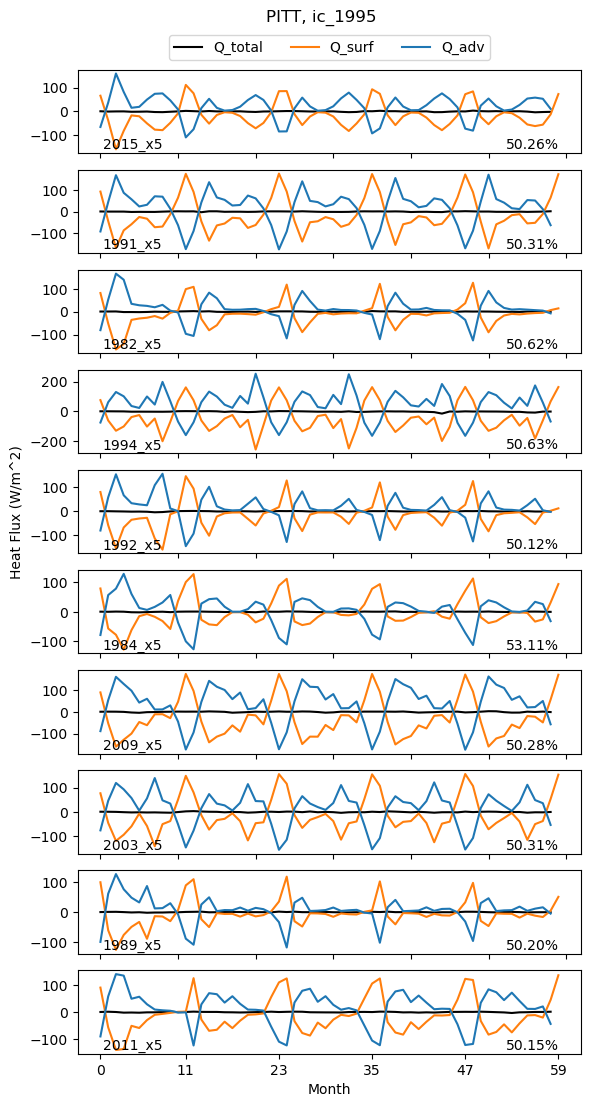

In [21]:
# Plot Qsurf and dT for each run

fig, axes = plt.subplots(10, 1, figsize=(6.5, 12))

i = 0
for forc in q_total_dict:
    ax = axes[i]
    ax.annotate(forc,xy=(0,0),xytext=(0.05,0.05),textcoords='axes fraction')
    
    ax.plot(q_total_dict[forc],label='Q_total',color='k')
    ax.plot(q_surf_dict[forc],label='Q_surf',color='tab:orange')
    ax.plot(q_adv_dict[forc],label='Q_adv',color='tab:blue')
    
    frac_str = '{:.2f}'.format(np.mean(q_surf_pct_dict[forc]))+'%'
    ax.annotate(frac_str,xy=(0,0),xytext=(0.85,0.05),textcoords='axes fraction')
    if i == 0:
        ax.legend(ncol = 3,bbox_to_anchor=(0.5,1.5),loc='upper center')
    elif i == 4: 
        ax.set_ylabel('Heat Flux (W/m^2)')
    if i == 9:
        ax.set_xlabel('Month')
        ax.set_xticks([0,11,23,35,47,59])
    else:
        ax.set_xticklabels([])

    i += 1

plt.suptitle(loc+', '+set)
plt.subplots_adjust(top=0.93)
    

Below cells are experimental code used for testing. 

In [94]:
print('Q_adv',q_adv.values[0:3])
print('Q adv = Q_est - Q_surf')
print('Q_est',q_est.values[0:3])
print('Q_surf',exp_q_surf.values[0:3])

Q_adv [ 69.93387 187.74045 172.71277]
Q adv = Q_est - Q_surf
Q_est [18.39102  22.531504 31.486622]
Q_surf [  81.38408   -51.542847 -165.20894 ]


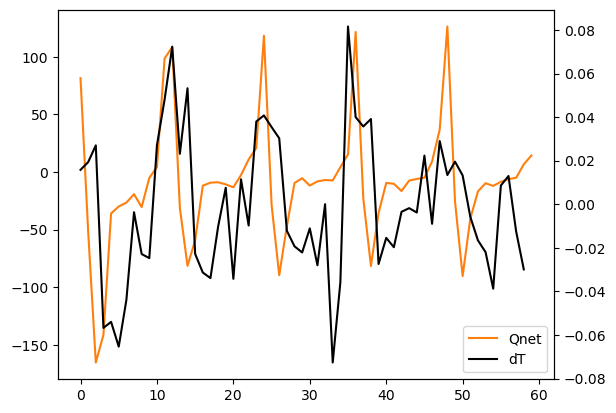

In [46]:
# Plot Qsurf and dT
fig, ax = plt.subplots()
l1, = ax.plot(exp_q_surf,label='Q_surf',color='tab:orange')
ax1 = ax.twinx()
l2, = ax1.plot(delta_T,label='dT',color='k')
lines = [l1, l2]
ax1.legend(lines, [line.get_label() for line in lines], loc='lower right')


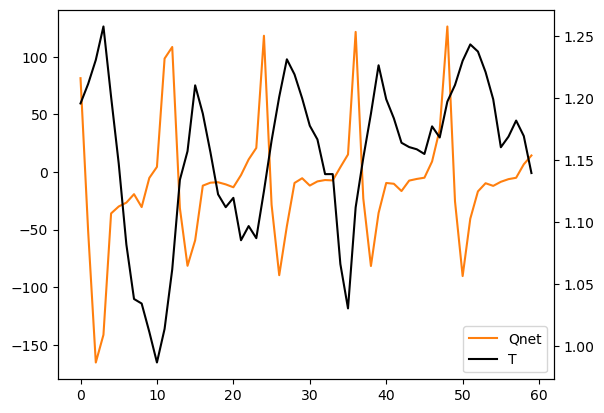

In [44]:
# Plot q_srf and T
fig, ax = plt.subplots()
l1, = ax.plot(exp_q_surf,label='Q_surf',color='tab:orange')
ax1 = ax.twinx()
l2, = ax1.plot(exp_T,label='T',color='k')
lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower right')


In [ ]:
# 